# Поиск оптимальной стратегии в непрерывных средах табличными методами

Продемонстрируем изученные ранее методы поиска оптимальной стратегии в средах с непрерывном меняющимися состояниями с помощью "табличных" агентов. Основной способ, позволяющий использовать "табличных" агентов в таких средах, заключается в дискретизации непрерывного пространства состояний среды. Рассмотрим две задачи: задача о вертикальном маятнике `CartPole` и задача о подъёме машинки в гору `MountainCar`.

В качестве метода обучения агента используем метод Q-learning (хотя можно использовать и другие методы, например, SARSA, ExpectedSARSA, методы МК).
Скопируем код "табличного" агента без изменений. Также скопируем код, реализующий Q-learning, добавив в него возможность уменьшать параметр шага обучния $\alpha$ с течением обучения.

In [21]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

class TableAgent:
    def __init__(self, env, eps = 0.1, alpha = 0.1):
        self.nA = env.action_space.n # число действий
        self.Q = defaultdict(lambda: np.zeros(self.nA))   # словарь для хранения оценок ценностей пар состояние-действие
        self.eps = eps               
        self.alpha = alpha           # параметр шага обучения
            
    def reset(self):
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    # выбор eps-жадного действия        
    def get_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.nA)

        return self.best_action(state)
    
    # выбор жадного действия        
    def best_action(self, state):
        return np.argmax(self.Q[state])
    
    def update(self, state, act, goal):
        # обновление оценки с постоянным шагом обновления
        self.Q[state][act] += self.alpha*(goal - self.Q[state][act])
        
    def get_Q(self, state, act):
        return self.Q[state][act]
  
    def play(self, env, n_episodes):
        for _ in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

In [25]:
from tqdm import tqdm
    
# алгоритм обучения, возврат: массив доходов
def QLearning_control(env, agent, n_episodes=10000, gamma = 1.0, 
                      eps_start=0.5, eps_decay = 1.0, eps_min = 0.01,
                     alpha_start=0.2, alpha_decay = 1.0, alpha_min = 0.01):
    agent.eps = eps_start
    # NEW: установка шага обучения
    agent.alpha = alpha_start
    
    for _ in tqdm(range(n_episodes)):
        state, _ = env.reset()

        # запускаем эпизод взаимодействия со средой        
        while True:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            best_action = agent.best_action(next_state)           
            upd_goal = reward + gamma * agent.get_Q(next_state, best_action)
            agent.update(state, action, upd_goal)
            
            state = next_state
            if terminated or truncated:
                break

        # уменьшение доли шагов исследования
        agent.eps = max(agent.eps * eps_decay, eps_min)
        # NEW: уменьшение шага обучения
        agent.alpha = max(agent.alpha * alpha_decay, alpha_min)   

Также удобно ввести функции, позволяющие сохранить обученную Q-таблицу и загрузить эту таблицу в агента из файла. Для этого используем библиотеку `pickle`.

In [23]:
import pickle

def save_Q(agent, name):
    # При сохранении напрямую pickle.dump(agent.Q,f) возникает ошибка Can't pickle local object,
    #  поскольку сохранятеся не словарь dict, а defaultdict. Поэтому переписываем все значения в обычный словарь
    f = open('savedModels/'+name+".pkl",'wb')
    dict_tmp = {}
    for key in agent.Q.keys():
        dict_tmp[key] = agent.Q[key]    
    pickle.dump(dict_tmp,f)
    f.close()
    return 'savedModels/'+name+".pkl"
    
def load_Q(agent, name):
    f = open(name,'rb')
    dict_tmp = pickle.load(f)
    f.close()
    agent.reset()
    for key in dict_tmp.keys():
        agent.Q[key] =  dict_tmp[key]

### Задача 1 о перевёрнутом маятнике

Рассмотрим задачу о вертикальном маятнике `CartPole`. Задача описана в 1983 году Э.Барто, Р.Саттоном. Суть в том, чтобы удерживать перевёрнутый маятник (англ. inverted pendulum) закреплённый на движущейся тележке, который может двигаться по прямой без трения. 

Особенности:

1. Цель удержать маятник в вертикальном положении в течении 500 шагов (в версии v1), толкая тележку влево\вправо.

2. Состояние: массив из 4-х чисел, которые дают информацию о положении тележки и маятника:

       [положение тележки, скорость тележки, угол наклона маятника, угловая скорость маятника]
    
        Положение тележки может меняться от -4.8 до 4.8.

        Скорость тележки может меняться от -$\infty$ до +$\infty$.
    
        Угол маятника может быть между -24 и +24 градусами относительно вертикали (или от -0.418 радиан до 0.418 радиан).
    
        Скорость изменения угла также может меняться от -$\infty$ до +$\infty$.

Начальное состояние - это вектор из 4-х значений, где каждая координата принимает значение в интервале [-0.05,0.05] случайным образом с равномерным распределением.

3. Действия дискретны: либо 0 для сдвига тележки влево, либо 1 для сдвига вправо.
4. Вознаграждения: +1 за каждый шаг, пока маятник находится в заданном интервале отклонений углов. 
5. Завершение происходит в следующих случаях: 

        когда маятник падает (отклонение более 12 градусов от вертикали), 
        когда тележка выезжает за экран (положение отклоняется больше, чем на 2.4 от центра), 
        когда достигнут максимум в 500 временных шагов.

In [7]:
# подгрузка необходимых пакетов
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm
# для избежания ошибки при отрисовки графиков
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# создание экземпляра среды
env = gym.make('CartPole-v1')
state, _ = env.reset()
print("Начальное состояние: ", state)

Начальное состояние:  [ 0.01084248  0.02651942  0.02185893 -0.04984801]


Демонстрацию среды можно запустить в отдельном окне с помощью `render_mode="human"`

In [11]:
env = gym.make('CartPole-v1', render_mode="human")
env.reset()

while True:
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
env.close()

При необходимости можно также получать картинку среды в `Jupyter Notebook` в режиме `render_mode="rgb_array"`.

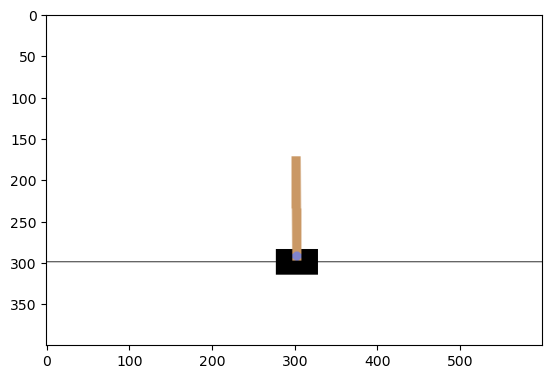

In [11]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

### Задача 1, способ 1: дискретизация округлением

Выведем максимальное и минимальное значения для элементов вектора состояния

In [13]:
env = gym.make('CartPole-v1')
print("Минимальные значения: ", env.observation_space.low)
print("Максимальные значения: ", env.observation_space.high)
env.observation_space

Минимальные значения:  [-4.8               -inf -0.41887903        -inf]
Максимальные значения:  [4.8               inf 0.41887903        inf]


Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

Напомним ограничения на интервал значений для элементов состояния.
   
    x-позиция: значения между -4.8 и 4.8
    x-скорость: от -inf до +inf, но ясно что скорость слишком большой быть не может.
    отклонение маятника от вертикали: от -0.418 до 0.418 радиан (или от -24 до 24 градусов)
    скорость изменения отклонения: от -inf до +inf, но ясно что скорость слишком большой быть не может.

Простейший способ дискретизации заключается в **округление значений** в векторе состояния до первой цифры после запятой.

Технически для модификации значений вектора состояний можно использовать класс-обёртку TransformObservation. Это позволит не менять код, реализующий метод обучения. В создаваемый класс-обёртку можно передать метод, который будет преобразовывать состояние по заданному правилу, например, производить дискретизацию значений с помощью округления. Для этого напишем метод `modifyObs()`.

Значения скоростей помимо округления мы еще ограничим по величине интервалом от -1 до 1.

In [15]:
import numpy as np
from gymnasium.wrappers import TransformObservation

def modifyObs(obs):
    obs1 = min(1.0, max(-1.0, np.round(obs[1], 1)))
    obs3 = min(1.0, max(-1.0, np.round(obs[3], 1)))
    return (np.round(obs[0], 1), obs1, np.round(obs[2], 1), obs3)

In [17]:
env = gym.make('CartPole-v1')
# создание экземпляры среды с обёрткой, передача среды, формулы изменения obs, и None, как указание того, что observation_space не поменялось
env = TransformObservation(env, modifyObs, None)

# проверка работы: напечатаем первые 10 состояний
env.reset()
for _ in range(10):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    print(state)

env.close()

(0.0, -0.2, 0.0, 0.3)
(0.0, 0.0, 0.0, 0.1)
(0.0, -0.2, 0.1, 0.4)
(0.0, -0.4, 0.1, 0.7)
(0.0, -0.6, 0.1, 1.0)
(-0.0, -0.4, 0.1, 0.7)
(-0.0, -0.6, 0.1, 1.0)
(-0.0, -0.4, 0.1, 0.8)
(-0.0, -0.6, 0.1, 1.0)
(-0.0, -0.4, 0.2, 0.9)


Обучим агента на 10000 эпизодах взаимодействия.

In [27]:
# Создание среды c обёрткой
env = gym.make('CartPole-v1')
env = TransformObservation(env, modifyObs, None)

n_episodes = 5000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)


# создание табличного агента
agent = TableAgent(env)

# обучение агента и получение доходов по эпизодам
QLearning_control(env, agent, n_episodes = n_episodes, gamma=0.99, 
                            eps_start=0.95, eps_decay = 0.9995, eps_min = 0.01,
                       alpha_start=0.95, alpha_decay = 0.9995, alpha_min = 0.01)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 256.87it/s]


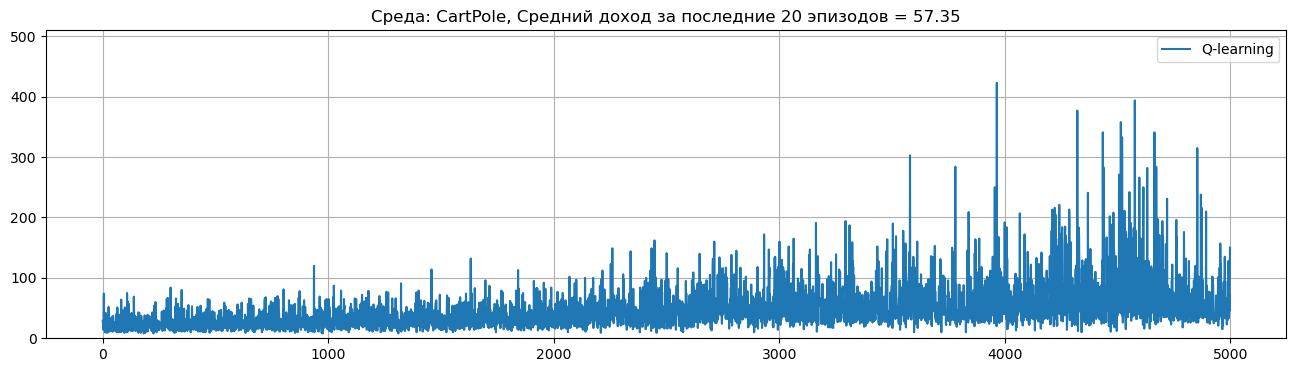

In [29]:
# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(0, 510)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("CartPole", returns, 'Q-learning')

Как видно из графика получаемых доходов за эпизод, доходы растут, но довольно медленно.

In [24]:
print(agent.alpha)
print(agent.eps)

0.0779320097103072
0.0779320097103072


Проведём симуляцию обученного агента и найдём средний доход за 100 эпизодов.

In [31]:
env = gym.make('CartPole-v1')
env = TransformObservation(env, modifyObs, None)

n_episodes = 100
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

agent.play(env, n_episodes)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.79it/s]

Средний доход:  76.26
Минимальный доход:  21.0


Можно вывести число состояний, хранящихся в Q-таблице на текущий момент.

In [33]:
Q_learned = agent.Q
len(Q_learned)

2589

Ниже можно запустить демонстрацию работы обученного агента.

In [39]:
# создание экземпляра среды
env = gym.make('CartPole-v1', render_mode='human')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()

# демонстрация работы агента
while True:
    # выбор действия жадно, относительно обученной Q функции
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    if terminated or truncated:
        break
        
print("Число шагов:", env.length_queue[-1])
# завершить взаимодействие со средой
env.close()

Число шагов: 127


Для более качественного результата можно проделать ещё большее число итераций.
Ниже есть код для подгрузки посчитанных значений после 50К итераций.

In [24]:
# Создание среды c обёрткой
env = gym.make('CartPole-v1')
env = TransformObservation(env, modifyObs, None)

n_episodes = 50000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env)

# обучение агента и получение доходов по эпизодам
gains = QLearning_control(env, agent, num_episodes = 50000, gamma=0.99, 
                            eps_start=0.9, eps_decay = 0.9999, eps_min = 0.001,
                       alpha_start=0.5, alpha_decay = 0.9999,  alpha_min = 0.01)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [07:17<00:00, 114.25it/s]


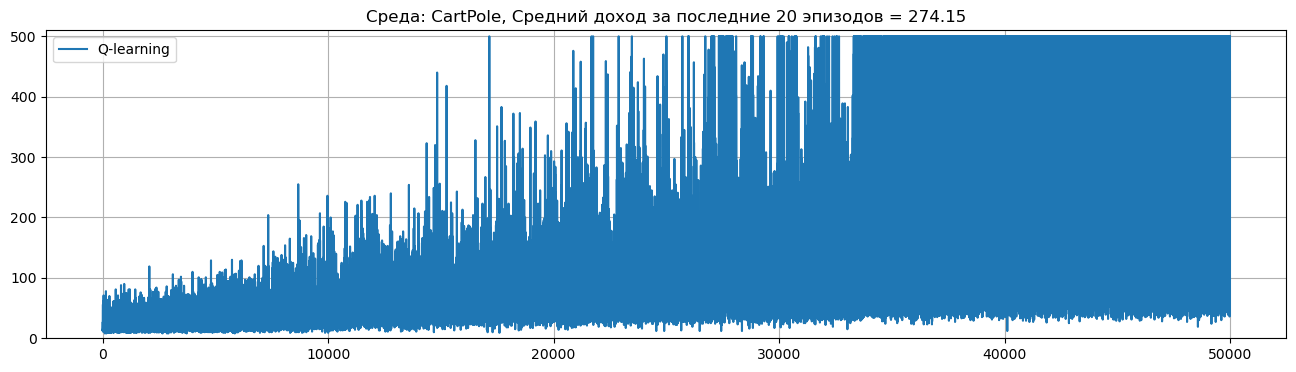

In [25]:
# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, gains, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(gains[-20:])))
    plt.plot(gains, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(0, 510)
    plt.show()
    
returns = np.array(env.return_queue)
plot_rewards("CartPole", returns, 'Q-learning')

Можно вывести число состояний, хранящихся в Q-таблице после 50K эпизодов обучения.

In [43]:
Q_learned = agent.Q
len(Q_learned)

4820

Результат обучения, то есть таблицу со значениями Q-функции, можно выгрузить во внешний файл.

In [27]:
#save_Q(agent,'CartPole_by_round_50K')

'savedModels/CartPole_by_round_50K.pkl'

Ниже можно подгрузить обученного агента после 50000 эпизодов обучения.

In [41]:
# Создание среды c обёрткой
env = gym.make('CartPole-v1')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

# создание табличного агента
agent = TableAgent(env)

load_Q(agent, 'savedModels/CartPole_by_round_50K.pkl')

Проведём симуляцию обученного агента и найдём средний доход за 100 эпизодов.

In [45]:
env = gym.make('CartPole-v1')
env = TransformObservation(env, modifyObs, None)

n_episodes = 100
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent.play(env, n_episodes)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.26it/s]

Средний доход:  245.81
Минимальный доход:  33.0


Ниже можно запустить демонстрацию работы обученного агента.

In [51]:
# создание экземпляра среды
env = gym.make('CartPole-v1', render_mode='human')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()

# демонстрация работы агента
while True:
    # выбор действия жадно, относительно обученной Q функции
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    if terminated or truncated:
        break
        
print("Число шагов:", env.length_queue[-1])
# завершить взаимодействие со средой
env.close()

Число шагов: 267


### Задача 1, способ 2: дискретизация с шагом

Рассмотрим ещё один способ дискретизации, который заключается в том, чтобы взять некоторый шаг дискретизации и провести равномерную дискретизацию интервала возможных значений. Размер шага дискретизации можно подобрать методом проб и ошибок, изучив скорость сходимости для различных шагов.

Более разумный подход заключается в том, чтобы нарисовать графики 4 значений по многим траекториям, посмотреть на распределение значений и подобрать подходящий способ дискретизации (возможно и не равномерной).

Продемонстрируем метод равномерной дискетизации с некоторым шагом, причём из информации о состоянии будем использовать только угол и скорость изменения угла. Положение тележки и её скорость вообще не будем передавать агенту.

Сделаем так, чтобы общее число дискретизированных углов равнялось 12, а скоростей углов - 24.
Для этого допустимый интервал углов $[-0.418,0.418]$ разобъём на 12 частей. Номер той части, куда попал текущий угол и будем передавать агенту. Для скорости изменения интервал формально не ограничен. Мы же его ограничим интервалом $[-48,48]$ в градусах\сек и аналогичным образом разобъём на 24 части. Номер той части, куда попала текущая скорость изменения угла и будем передавать агенту.

Пусть $Lb$ нижняя граница допустимого интервала, $Ub$ верхняя граница допустимого интервала, $N$ число частей интервала. Тогда шаг дискретизации равен

$$ step = \frac{Ub-Lb}{N}$$

Тогда интервал $[Lb, Ub]$ будет разбит на $N$ частей длины $step$.
Чтобы для числа $x\in [Lb, Ub]$ определить индекс той части, куда это число $x$ попадает, можно использовать формулу:

$$I_x = trunc(\frac{x - Lb}{step})$$

Здесь функция `trunc()` отбрасывает дробную часть входящего аргумента, приводя его к целому. Если число $x$ лежало внутри интервала $[Lb,Ub]$, то индекс $I_x$ будет от $0$ до $N-1$. Если число $x$ было вне интервала, то надо дополнительно обеспечить, чтобы значения $I_x<0$ стали равны $0$, а значения $I_x>N-1$ стали равны $N-1$.

Ниже приведён пример описанных выше вычислений. Для того, чтобы получить нижние и верхние границы изменений значения вектора состояний, надо использовать `env.observation_space.low` и `env.observation_space.high`.

In [53]:
import math

env = gym.make('CartPole-v1')

n_bins = [12 , 24]
lower_bounds = np.array([ env.observation_space.low[2], -math.radians(48) ])
# math.radians() переводит углы в радианы
upper_bounds = np.array([ env.observation_space.high[2], math.radians(48) ])
discrete_step = (upper_bounds - lower_bounds)/n_bins
discrete_step

array([0.06981317, 0.06981317])

Напишем соответвующую обёртку.

In [57]:
import math
from gymnasium.wrappers import TransformObservation

n_bins = [12 , 24]
lower_bounds = np.array([ env.observation_space.low[2], -math.radians(48) ])
upper_bounds = np.array([ env.observation_space.high[2], math.radians(48) ])
discrete_step = (upper_bounds - lower_bounds)/n_bins
discrete_step

def modifyObs(obs):
    state_d = np.int8((obs[2:4] - lower_bounds)/discrete_step)
    state_d = tuple([min(11, max(0, state_d[0])), min(23, max(0, state_d[1]))])    
    return state_d

Проверим работу класса-обёртки.

In [59]:
env = gym.make('CartPole-v1')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

# проверка работы: напечатаем первые 5 состояний
env.reset()
for _ in range(5):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    print(state)

env.close()

(6, 15)
(6, 11)
(6, 7)
(6, 12)
(6, 8)


Обучим агента по методу Q-leraning. При создании среды увеличим также временное ограничение на число шагов в эпизоде. При таком подходе хватит порядка 2000 эпизодов.

In [61]:
# Создание среды c обёрткой
env = gym.make('CartPole-v1', max_episode_steps=5000)
env = TransformObservation(env, modifyObs, None)
n_episodes = 2000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env)

# обучение агента и получение доходов по эпизодам
QLearning_control(env, agent, n_episodes = n_episodes, gamma=0.99, 
                            eps_start=0.99, eps_decay = 0.997, eps_min = 0.001,
                       alpha_start=0.9, alpha_decay = 0.999,  alpha_min = 0.02)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.27it/s]


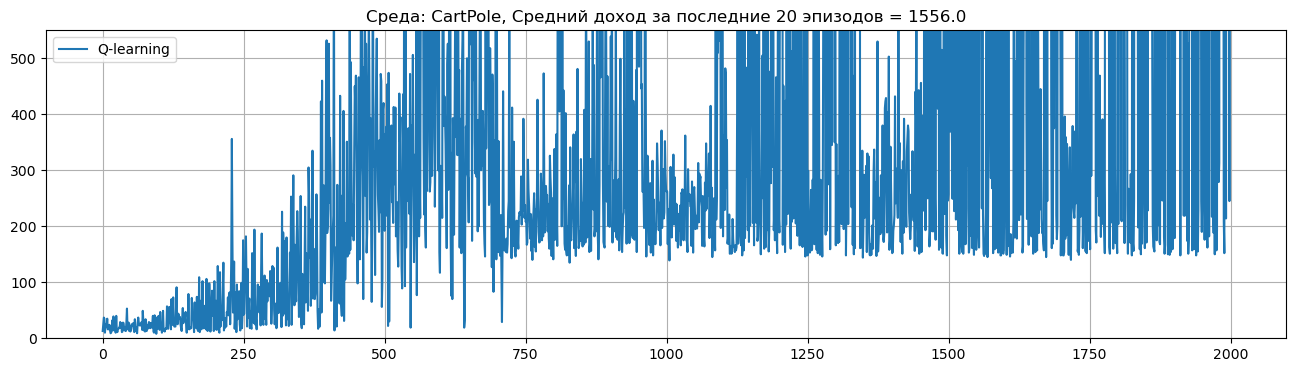

In [63]:
# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(0, 550)
    plt.show()
    
returns = np.array(env.return_queue)    
plot_rewards("CartPole", returns, 'Q-learning')

In [51]:
agent.eps

0.002431934187145619

Как ясно из графика доходов, полученных в ходе обучения, метод равномерной дискретизации с учётом только угла наклона и его скорости изменения показывает более эффективное обучение. Уже к 2000 итерации обучения минимальный доход приближается к 200. При этом количество записей в таблице с Q-функцией значительно меньше, по сравнению с методом на основе округления значений.  Общее количество значений Q-функции равноо $12*24*2 = 576$ значений, в отличии от нескольких тысяч значений в первом варианте. При этом фактически используется меньшее число записей.

In [65]:
Q_learned = agent.Q
print("Число записей в таблице с Q-функцией:", len(Q_learned))

Число записей в таблице с Q-функцией: 173


Для подгрузки агента с графиком обучения выше, можно использовать следующую строчку.

In [108]:
#save_Q(agent, 'CartPole_by_dicrtetize_5K')

'savedModels/CartPole_by_dicrtetize_5K.pkl'

In [107]:
load_Q(agent, 'savedModels/CartPole_by_dicrtetize_5K.pkl')

Проведём симуляцию обученного агента и найдём средний доход за 100 эпизодов.

In [67]:
env = gym.make('CartPole-v1')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env, 100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 86.15it/s]

Средний доход:  377.93
Минимальный доход:  147.0


Ниже можно запустить демонстрацию работы агента.

In [77]:
env = gym.make('CartPole-v1', render_mode='human')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()

# демонстрация работы агента
while True:
    # выбор действия жадно, относительно обученной Q функции
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    if terminated or truncated:
        break
        
print("Число шагов:", env.length_queue[-1])
# завершить взаимодействие со средой
env.close()

Число шагов: 500


### Задача 2

Рассмотрим задачу о подъёме машины на гору MountainCar.
Задача предложена A. Муром в 1990. Движущаяся тележка должна въехать на холм из низины. Однако, тележка недостаточно мощная, чтобы сделать это сразу. Необходимо раскачаться двигаясь влево-вправо и набрать достаточно кинетической энергии чтобы взобраться на холм. Особенности:

    1. Цель: въехать тележкой на вершину холма (позиция 0.5)
    2. Состояние: два числа, которые дают информацию о положении и скорости тележки по оси Ox, а именно
        
        [положение, скорость]
        
Положение изменяется в интервале [-1.2,0.6], скорость изменяется в интервале [-0.07,0.07]. Тележка стартует в случайном положении от -0.6 до -0.4 с нулевой скоростью. В данном случае агенту доступна лишь частичная информация о состоянии среды (полная информация включала бы x-, y-координаты тележки и вектор скорости). Тем не менее доступной информации достаточно, чтобы решить задачу обучения.

    3. Действия: [0,1,2], где 0 толкнуть влево, 1 не толкать, 2 толкнуть вправо.
    4. Вознаграждение: -1 за каждый временной шаг.
    5. Завершение: либо достижение вершины холма, либо достигнут максимум в 200 временных шагов.       

In [93]:
env = gym.make('MountainCar-v0')
state, _ = env.reset()
print("Начальное состояние: ", state)

Начальное состояние:  [-0.4410112  0.       ]


In [91]:
env = gym.make('MountainCar-v0', render_mode="human")
env.reset()
for _ in range(200):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
env.close()

Чтобы использовать изученные выше табличные методы, проведём дискретизацию состояния с помощью равномерной дискретизации. Выведем максимальное и минимальное значения для элементов вектора состояния

In [95]:
print("Минимальные значения: ", env.observation_space.low)
print("Максимальные значения: ", env.observation_space.high)

Минимальные значения:  [-1.2  -0.07]
Максимальные значения:  [0.6  0.07]


Используем дискретизацию пространства состояний с помощью такого шага, чтобы получить в итоге по 20 возможных значения для каждого из двух параметров.

Опять же для технической реализации используем класс обёртку.

In [97]:
from gymnasium.wrappers import TransformObservation

# Вычислим шаг дискретизации
lower_bounds = env.observation_space.low
upper_bounds = env.observation_space.high
discrete_step = (upper_bounds - lower_bounds)/[20, 20]        
    
def modifyObs(obs):
    return tuple(np.int8((obs - lower_bounds)/discrete_step))

In [99]:
env = gym.make('MountainCar-v0')
env = TransformObservation(env, modifyObs, None)

# проверка работы: напечатаем первые 5 состояний
env.reset()
for _ in range(5):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    print(state)

env.close()

(8, 10)
(8, 10)
(8, 10)
(8, 10)
(8, 9)


Проведём обучения агента.

In [101]:
# Создание среды c обёрткой
env = gym.make('MountainCar-v0')
env = TransformObservation(env, modifyObs, None)
n_episodes = 8000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env)

# обучение агента и получение доходов по эпизодам
QLearning_control(env, agent, n_episodes = n_episodes, gamma=0.99, 
                            eps_start=0.9, eps_decay = 0.9992, eps_min = 0.005,
                       alpha_start=0.9, alpha_decay = 0.999,  alpha_min = 0.01)

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:50<00:00, 158.45it/s]


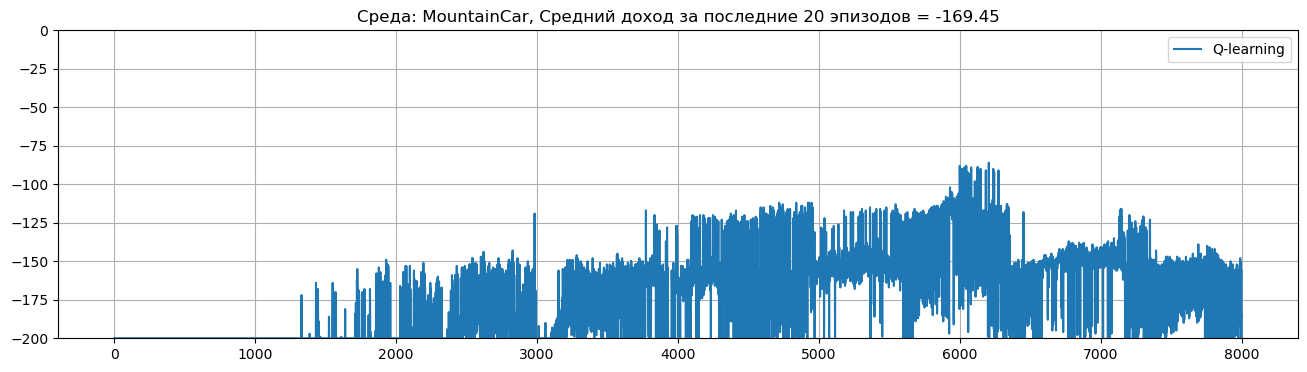

In [105]:
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-200, 0)
    plt.show()

returns = np.array(env.return_queue)    
plot_rewards("MountainCar", returns, 'Q-learning')

Сначала агент обучается медленно, поскольку надо случайными действия забраться на холм, но как только это сделано первый раз (после примерно 1500-го эпизода), информация об успешных действиях распространяется по Q-таблице и агент действует всё лучше и лучше.

In [107]:
print(agent.alpha)
print(agent.eps)

0.01
0.005


Для подгрузки агента, обученного на 10K эпизодах, можно использовать следующую строчку.

In [70]:
#save_Q(agent, 'MountCar_by_dicrtetize_10K')

# Создание среды c обёрткой
env = gym.make('MountainCar-v0')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

# создание табличного агента
agent = TableAgent(env)

load_Q(agent, 'savedModels/MountCar_by_dicrtetize_10K.pkl')

Проведём симуляцию обученного агента и найдём средний доход за 100 эпизодов.

In [109]:
# создание экземпляра среды
env = gym.make('MountainCar-v0')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env, 100)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 197.87it/s]

Средний доход:  -174.82
Минимальный доход:  -200.0


Ниже можно запустить демонстрацию работы агента.

In [115]:
# создание экземпляра среды
env = gym.make('MountainCar-v0', render_mode='human')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()

# демонстрация работы агента
while True:
    # выбор действия жадно, относительно обученной Q функции
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    if terminated or truncated:
        break
        
print("Число шагов:", env.length_queue[-1])
# завершить взаимодействие со средой
env.close()

Число шагов: 197
